# Web Scrape & EDA of Stratus.network
---
- Made by: Philip Sinnott | Last modified: 2023-01-28
- GitHub: @philipsinnott
- Blog: https://sinnott.netlify.app/

# 1. Web scraping
---

In [1]:
# Imports
from bs4 import BeautifulSoup
import requests
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# URLs
total = "https://stratus.network/leaderboard/*,*,*,stratus/wins/1"
s15 = "https://stratus.network/leaderboard/stratus15,*,*,stratus-ranked/wins/1"

# Get html data and create soup object
data = requests.get(total).text
soup = BeautifulSoup(data, "html.parser")

## 1.1 Acquire data

In [3]:
# Get names of each column header
t_head = soup.find_all("tr", "MuiTableRow-root MuiTableRow-head")

# Append each header to a list
column_headers = []
for i in t_head:
    for j in i.find_all("th"):
        column_headers.append(j.text)

In [4]:
# Get data from top 100 players
t_body = soup.find_all("tr", class_="MuiTableRow-root")
rank_rows = soup.find_all("tr", class_="MuiTableRow-root")
players_data = []
current_player = []
count = 0
for i, rank_row in zip(t_body, rank_rows):
    rank = rank_row.find("td", class_="MuiTableCell-root MuiTableCell-body jss41 MuiTableCell-alignRight")
    if rank:
        current_player.append(rank.text)
    for j in i.find_all("span"):
        data = j.text.strip()
        current_player.append(data)
    if current_player:
        players_data.append(current_player)
    current_player = []
if current_player:
    players_data.append(current_player)
players_data[0]

['#1',
 'Heldd',
 '3,881',
 '87,535',
 '88,620',
 '0.99',
 '1.5M',
 '12.01/game',
 '22.5\u2006/min',
 '2.81',
 '38%',
 '969',
 '56,436',
 '-626.9']

## 1.2 Transform data from list objects to Pandas DataFrame

In [5]:
# Creating the df and modifying cols/rows so we can eventually use the data for visualization
df = pd.DataFrame(players_data, columns=column_headers)
df.rename(columns={"#":"Ranking"}, inplace=True)
df["Kills per Game"] = df["Kills per Game"].str.removesuffix("/game")
df["Damage Dealt per Minute"] = df["Damage Dealt per Minute"].str.removesuffix("\u2006/min")
df["Ranking"] = df["Ranking"].str.replace("#", "")
df["Bow Accuracy"] = df["Bow Accuracy"].str.replace("%", "")

df.head(1)

,Ranking,Player,Wins,Kills,Deaths,KDR,Damage Dealt,Kills per Game,Damage Dealt per Minute,Melee/Bow Damage Ratio,Bow Accuracy,Flags,Golden Apples Eaten,Rating
0,1,Heldd,"3,881","87,535","88,620",0.99,1.5M,12.01,22.5,2.81,38,969,"56,436",-626.9


In [6]:
# More needed modifications of the data

# Remove commas
for col in df.columns:
    df[col] = df[col].str.replace(",", "")

# Transform the specified cols into numerical
for col in df.columns[[0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13]]:
    #print(col)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Store bow accuracy metric in float instead of percentage
df["Bow Accuracy"] = df["Bow Accuracy"].apply(lambda x: x / 100)

# Print info and make sure all columns except for "Player" are of numerical type
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  100 non-null    int64  
 1   Player                   100 non-null    object 
 2   Wins                     100 non-null    int64  
 3   Kills                    100 non-null    int64  
 4   Deaths                   100 non-null    int64  
 5   KDR                      100 non-null    float64
 6   Damage Dealt             100 non-null    object 
 7   Kills per Game           100 non-null    float64
 8   Damage Dealt per Minute  100 non-null    float64
 9   Melee/Bow Damage Ratio   100 non-null    float64
 10  Bow Accuracy             100 non-null    float64
 11  Flags                    100 non-null    int64  
 12  Golden Apples Eaten      100 non-null    int64  
 13  Rating                   100 non-null    float64
dtypes: float64(6), int64(6), ob

In [7]:
# Show values in full length, e.g. "1.5M" --> "1500000" and "500k" --> "500000" for visualization purposes
df["Damage Dealt"] = df["Damage Dealt"].apply(lambda x: pd.to_numeric(x.replace('M',''))*1000000 if 'M' in x
                                              else pd.to_numeric(x.replace('k',''))*1000 if 'k' in x else pd.to_numeric(x))
df["Damage Dealt"] = df["Damage Dealt"].astype(int)
df

,Ranking,Player,Wins,Kills,Deaths,KDR,Damage Dealt,Kills per Game,Damage Dealt per Minute,Melee/Bow Damage Ratio,Bow Accuracy,Flags,Golden Apples Eaten,Rating
0,1,Heldd,3881,87535,88620,0.99,1500000,12.01,22.5,2.81,0.38,969,56436,-626.9
1,2,PiiinguinFelix,2394,54842,49278,1.11,880000,13.80,25.0,3.22,0.42,727,42917,9842.6
2,3,sil4nt,2324,56953,60035,0.95,997000,11.26,22.5,2.82,0.36,280,30311,-17.9
3,4,lilkvneki77,2214,47136,56919,0.83,847000,11.37,23.0,3.55,0.38,569,49308,-11073.2
4,5,Kikzo,2120,52043,47861,1.09,856000,13.61,25.0,2.99,0.42,401,39505,8921.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,iskiiii56,729,17323,15445,1.12,292000,13.14,24.0,2.95,0.41,172,18014,4410.5
96,97,URHANDSINMYPANTS,728,17023,18985,0.90,297000,11.59,22.5,3.48,0.39,135,0,-1031.4
97,98,akashironaples,721,16179,15300,1.06,284000,12.34,24.0,2.52,0.39,167,20134,3917.7
98,99,smere,720,12412,23251,0.53,240000,7.14,16.0,4.05,0.28,258,11266,-16184.4


# 2 EDA
---

## 2.1 Damage Dealt per Minute

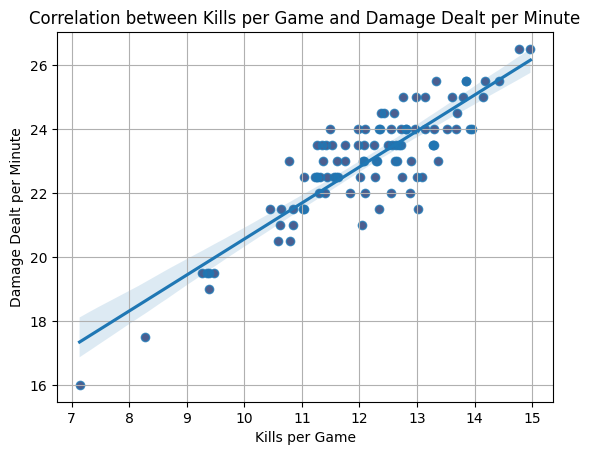

In [15]:
# create scatter plot
plt.scatter(df['Kills per Game'], df['Damage Dealt per Minute'], marker='o', s=20, c='red')

# add x and y labels
plt.xlabel('Rating')
plt.ylabel('Kills')

# add a linear regression line
sns.regplot(x='Kills per Game', y='Damage Dealt per Minute', data=df)

# add a title
plt.title('Correlation between Kills per Game and Damage Dealt per Minute')

# add grid
plt.grid()

# show plot
plt.show()

In [17]:
# Locate players with most damage dealt per minute
top_n_players = df.nlargest(20, 'Damage Dealt per Minute')
print(top_n_players[['Player', 'Damage Dealt per Minute']])

              Player  Damage Dealt per Minute
20          Azerdium                     26.5
63  xzXaRfGa166akDpl                     26.5
11             Crine                     25.5
42           Amiinos                     25.5
82            cityxl                     25.5
68    justsamithings                     25.5
88             ontas                     25.5
16            Levier                     25.0
1     PiiinguinFelix                     25.0
4              Kikzo                     25.0
32           cityxl_                     25.0
19              Bhng                     25.0
90         Comptable                     25.0
8           sheepzer                     24.5
44            iNowZe                     24.5
5              Ceive                     24.5
83            Alvvin                     24.5
13             zamph                     24.0
41              grq_                     24.0
94        Kirikoupen                     24.0


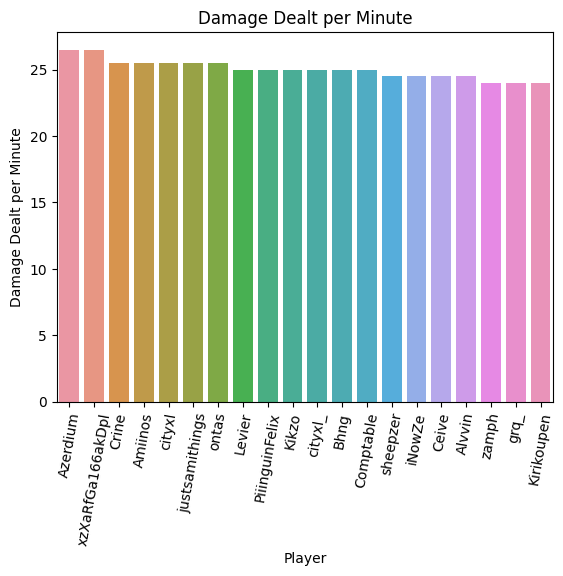

In [21]:
# Plot the data
sns.barplot(x="Player", y="Damage Dealt per Minute", data=top_n_players)

# add x and y labels
plt.xlabel('Player')
plt.ylabel('Damage Dealt per Minute')

# add a title
plt.title('Damage Dealt per Minute')

# rotate x-axis labels by 45 degrees
plt.xticks(rotation=80)

# show plot
plt.show()

## 2.2 Rating

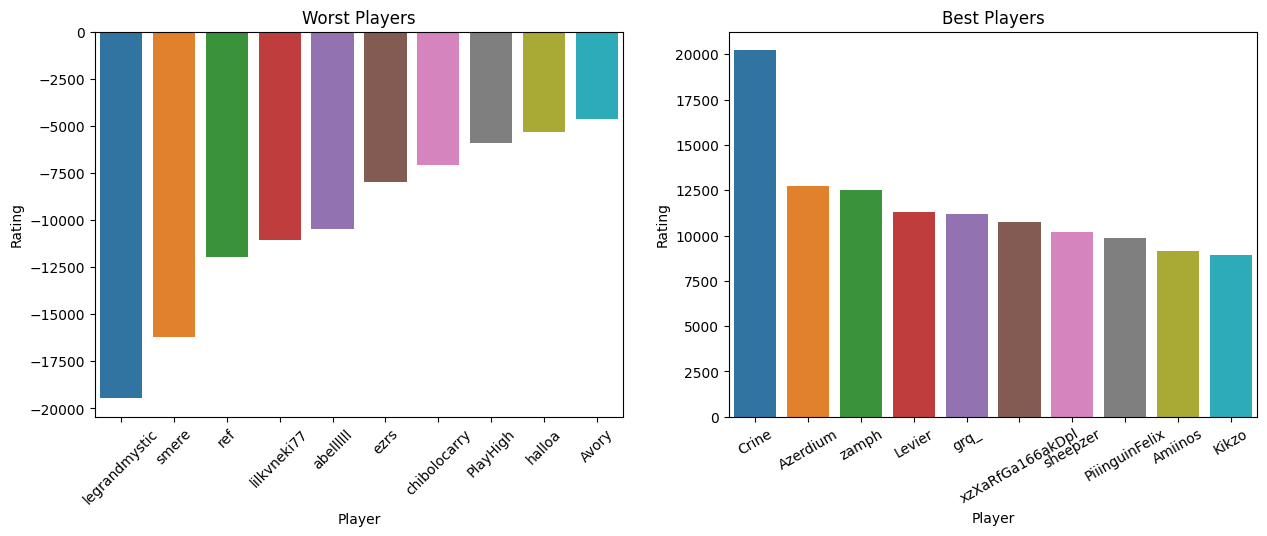

In [22]:
# Sort the dataframe in descending order of rating
df = df.sort_values(by='Rating',ascending=False)

# Get the top 10 players with the worst rating
worst_players = df.nsmallest(10, 'Rating')

# Get the top 10 players with the best rating
best_players = df.nlargest(10, 'Rating')

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Create a bar chart for the top 10 players with the worst rating
sns.barplot(x="Player", y="Rating", data=worst_players,ax=ax1)
ax1.set_title("Worst Players")
ax1.set_xlabel("Player")
ax1.set_ylabel("Rating")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Create a bar chart for the top 10 players with the best rating
sns.barplot(x="Player", y="Rating", data=best_players,ax=ax2)
ax2.set_title("Best Players")
ax2.set_xlabel("Player")
ax2.set_ylabel("Rating")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)

# Show plot
plt.show()

## 2.3 Bow accuracy / Flags

In [40]:
top_players = df.sort_values(by='Bow Accuracy', ascending=False).head(30)
top_players

,Ranking,Player,Wins,Kills,Deaths,KDR,Damage Dealt,Kills per Game,Damage Dealt per Minute,Melee/Bow Damage Ratio,Bow Accuracy,Flags,Golden Apples Eaten,Rating
62,63,Caqs,896,19739,18108,1.09,364000,11.48,24.0,1.61,0.51,161,16126,4465.0
57,58,serti,934,22342,23256,0.96,401000,11.98,23.5,2.49,0.50,279,18235,1758.2
54,55,sillyguy47,943,21240,17437,1.22,399000,11.52,23.5,1.38,0.50,195,12011,8901.6
11,12,Crine,1525,41988,28076,1.50,640000,14.43,25.5,2.23,0.49,425,19935,20235.0
66,67,MiniAnht,858,19053,18843,1.01,343000,12.10,24.0,2.33,0.48,174,12418,2366.6
8,9,sheepzer,1611,35872,31599,1.14,618000,12.42,24.5,2.46,0.46,490,35154,10216.2
42,43,Amiinos,1035,25922,22537,1.15,445000,13.33,25.5,2.77,0.46,190,35550,9147.8
32,33,cityxl_,1134,26180,23624,1.11,457000,12.99,25.0,2.48,0.46,122,39951,7887.3
65,66,SoulSand,880,18261,21964,0.83,328000,10.45,21.5,2.32,0.46,158,686,-3632.6
63,64,xzXaRfGa166akDpl,886,25367,18476,1.37,393000,14.97,26.5,2.44,0.45,103,16388,10726.1


In [72]:
non_eu_players = ['Caqs','sillyguy47','serti','Crine','MiniAnht','SoulSand','Levier','Kirikoupen','Algerie','AdamChen','thxchase'
                 ,'ReflexeZ', 'Blaszczak', 'Ceive', 'ssharpy', 'Sktchi', 'Gental', 'baob', 'PlayHigh']
#print(len(non_eu_players))
non_eu_df = df[df['Player'].isin(non_eu_players)]
eu_df = df[~df['Player'].isin(non_eu_players)]
top_30_non_eu_players_bow_acc = non_eu_df.nlargest(17,'Bow Accuracy')
top_30_eu_players_bow_acc = eu_df.nlargest(13,'Bow Accuracy')

top_30_non_eu_players_flags = non_eu_df.nlargest(17,'Flags')
top_30_eu_players_flags = eu_df.nlargest(13,'Flags')

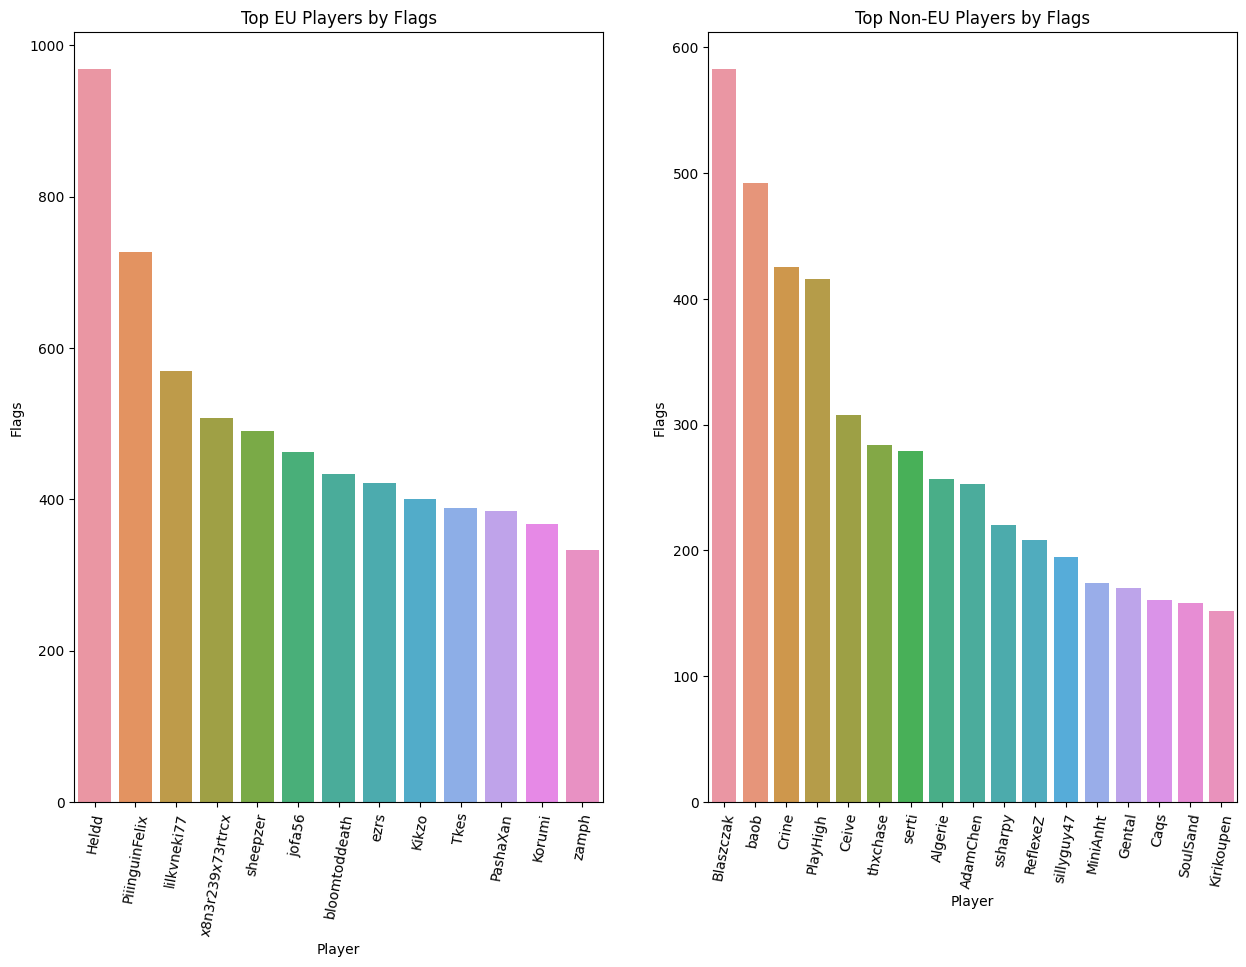

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.barplot(x="Player", y="Flags", data=top_30_eu_players_flags, ax=ax[0])
ax[0].set_title('Top EU Players by Flags')
ax[0].set_xlabel('Player')
ax[0].set_ylabel('Flags')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=80)

sns.barplot(x="Player", y="Flags", data=top_30_non_eu_players_flags, ax=ax[1])
ax[1].set_title('Top Non-EU Players by Flags')
ax[1].set_xlabel('Player')
ax[1].set_ylabel('Flags')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=80)

plt.show()

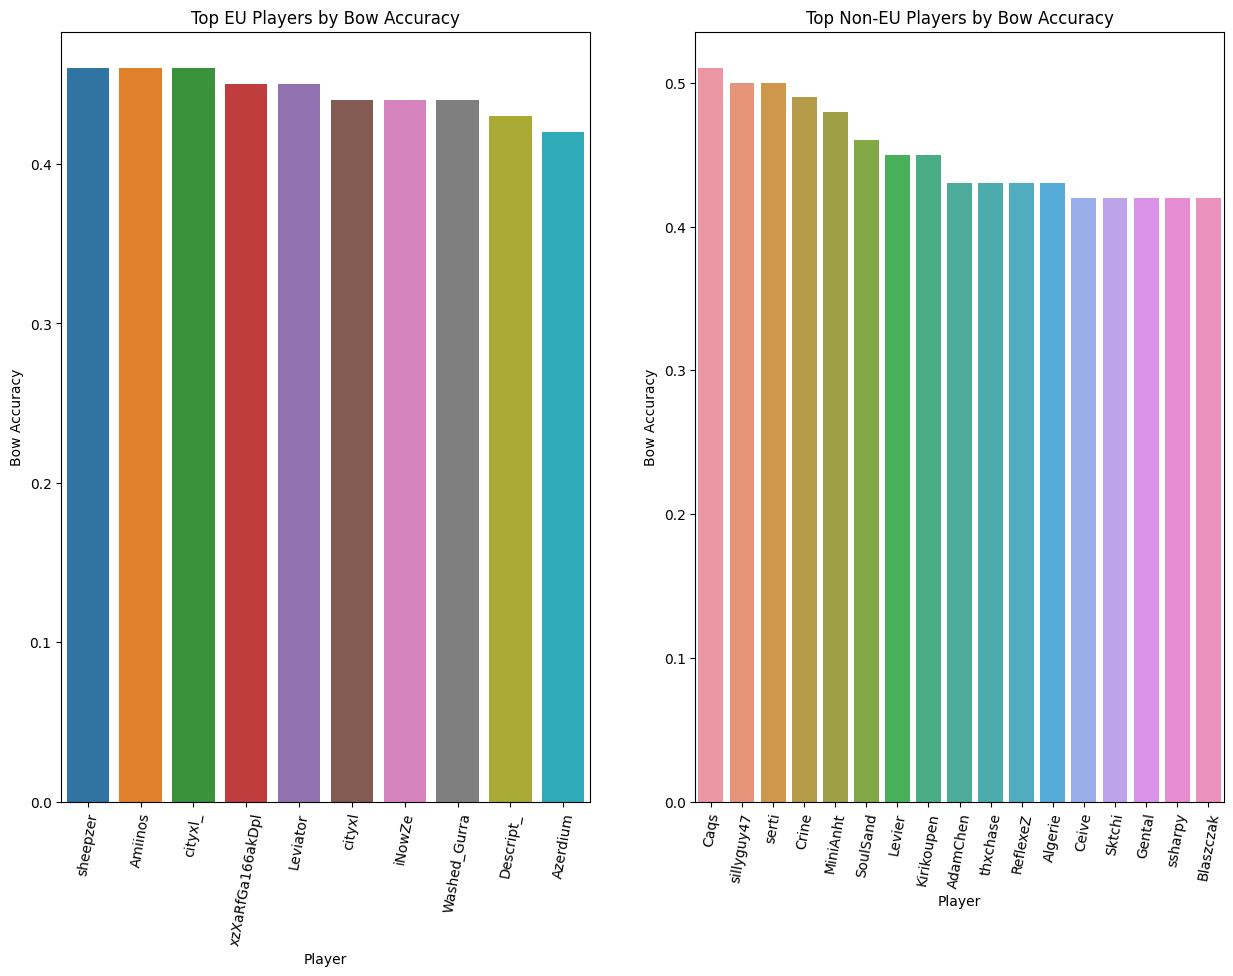

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.barplot(x="Player", y="Bow Accuracy", data=top_30_eu_players_bow_acc, ax=ax[0])
ax[0].set_title('Top EU Players by Bow Accuracy')
ax[0].set_xlabel('Player')
ax[0].set_ylabel('Bow Accuracy')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=80)

sns.barplot(x="Player", y="Bow Accuracy", data=top_30_non_eu_players_bow_acc, ax=ax[1])
ax[1].set_title('Top Non-EU Players by Bow Accuracy')
ax[1].set_xlabel('Player')
ax[1].set_ylabel('Bow Accuracy')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=80)

plt.show()

## 2.4 Misc

<AxesSubplot: title={'center': 'Correlation matrix'}>

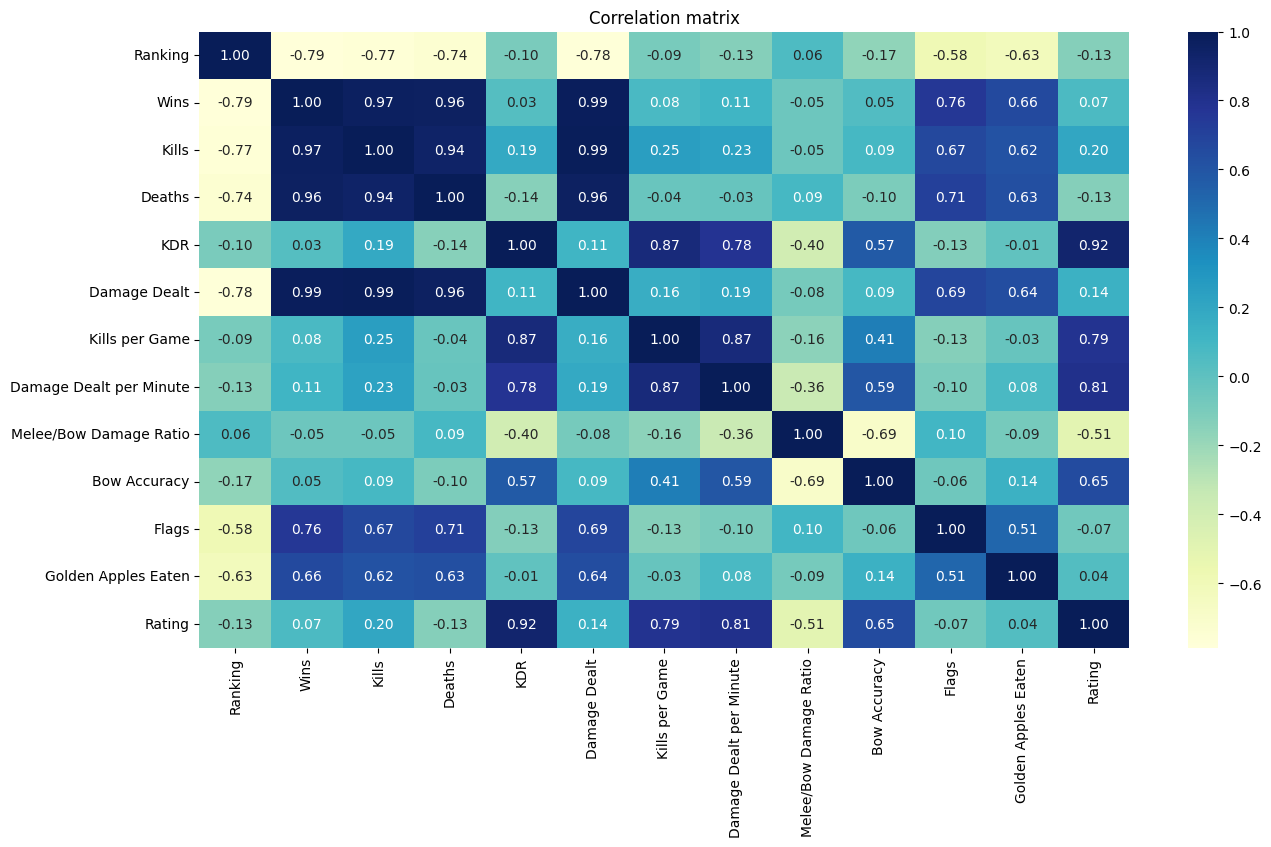

In [12]:
# Create correlation matrix to determine strongest correlation 
df_num = df.loc[:, df.columns != "Player"]
plt.figure(figsize=(15,8))
plt.title("Correlation matrix")
sns.heatmap(df_num.corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

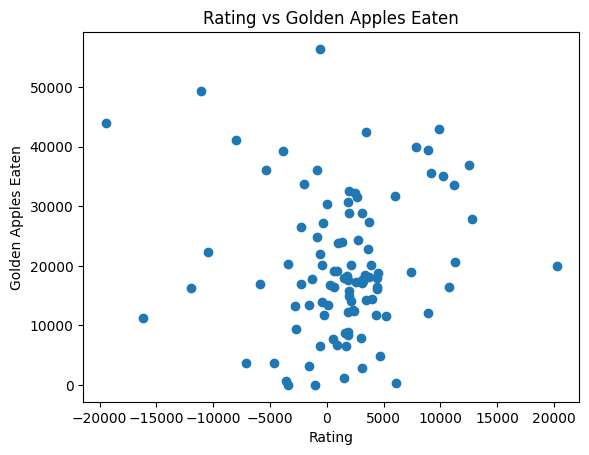

In [68]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.scatter(df['Rating'], df['Golden Apples Eaten'])

# Add x and y labels
plt.xlabel('Rating')
plt.ylabel('Golden Apples Eaten')

# Add a title
plt.title('Rating vs Golden Apples Eaten')

# Show plot
plt.show()


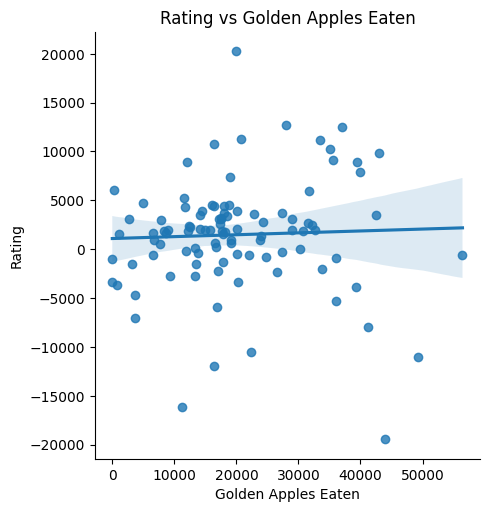

In [66]:
sns.lmplot(x='Golden Apples Eaten', y='Rating', data=df)
plt.title('Rating vs Golden Apples Eaten')
plt.xlabel('Golden Apples Eaten')
plt.ylabel('Rating')
plt.show()